## Marching Cubes with Laplacian Smoothing
(This Lab demands the package [PyMCubes](https://github.com/pmneila/PyMCubes) and [scikit-image](http://scikit-image.org))

In [1]:
import numpy as np
import mcubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def fun(x, y, z):
    # you can make this whatever you'd like
    return np.cos(x) + np.cos(y) + np.cos(z)

# grid size
n = 30j   # complex number bc mgrid receives complex as input

# create 3D grid
X, Y, Z = np.pi*np.mgrid[-1:1:n,-1:1:n,-1:1:n]

# defining a function in the grid
f = fun(X,Y,Z)

#computing the isosurface 0
vertices, triangles = mcubes.marching_cubes(f, 0)


# mcubes do not return a consistent mesh
# vertices are repeated in the list of vertices
# print(vertices[np.where(vertices[:,0]==0.)])

In [2]:
# use scikit-image's marching cubes ignore those repeat vertices
from skimage.measure import marching_cubes_lewiner as mc_lewiner

vertices, triangles, normals, values = mc_lewiner(f, 0)

print(vertices.shape)
print(triangles.shape)

(3336, 3)
(6344, 3)


<IPython.core.display.Javascript object>


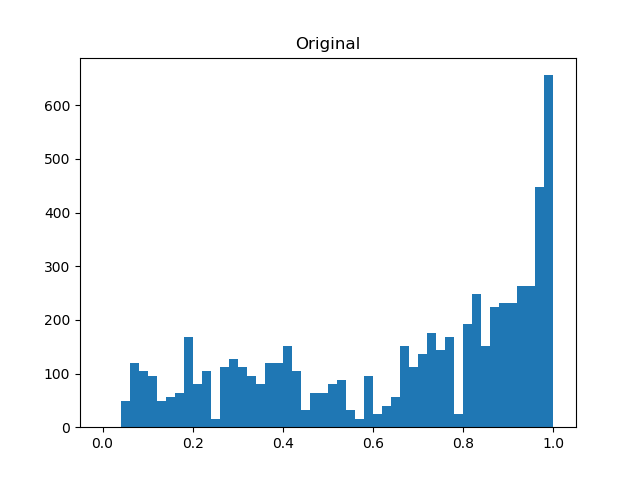

Area of the surface: 1981.04345703125
Average ratio q=2r/R: 0.6556409001350403
0.00193177


In [3]:
def vertices_to_side_length(T,V):
    def euc_distance(vv,uu):
        return np.sqrt(np.sum(np.square(vv-uu),axis=1))
    v0 = V[T[:,0],:]
    v1 = V[T[:,1],:]
    v2 = V[T[:,2],:]
    return np.vstack((euc_distance(v0,v1),euc_distance(v0,v2),euc_distance(v1,v2))).T

def cal_semiperimeter(T):
    return np.sum(T,axis=1)/2

# compute the area of each triangle mesh
def cal_area(T):
    sp = cal_semiperimeter(T)
    return np.sqrt(sp*(sp-T[:,0])*(sp-T[:,1])*(sp-T[:,2]))

# compute the inradius
def cal_inradius(T):
    return cal_area(T)/cal_semiperimeter(T)

# compute the circumradius
def cal_circumradius(T):
    return T[:,0]*T[:,1]*T[:,2]/4/cal_semiperimeter(T)/cal_inradius(T)

def cal_ratio(T):
    return 2*cal_inradius(T)/cal_circumradius(T)

def draw_histogram(T,V,title):
    tsl = vertices_to_side_length(T,V)
    ta = cal_area(tsl)
    tr = cal_ratio(tsl)
    figure = plt.figure()
    plt.title(title)
    plt.hist(tr,50,(0,1))
    plt.show()
    print("Area of the surface: {}".format(np.sum(ta)))
    print("Average ratio q=2r/R: {}".format(np.mean(tr)))
    print(ta.min())
    
draw_histogram(triangles,vertices,"Original")

k=1:


<IPython.core.display.Javascript object>


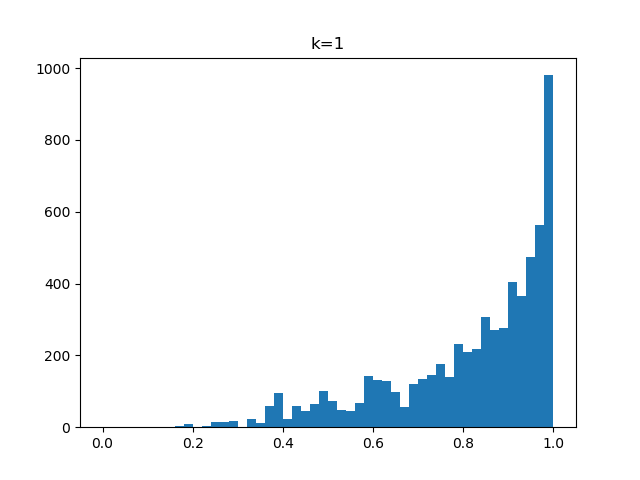

Area of the surface: 1852.3585130435488
Average ratio q=2r/R: 0.8143723927566953
0.0460473363813


In [4]:
# Computing the Laplacian smoothing (FILL IN THE FOLLOWING)
n = vertices.shape[0]
L = np.zeros((n,n))

# LUIS'S METHOD (simplest computationally, maybe not most intuitive) #
# build L grid ((i, j) is weighted = 1 if a triangle has a corner there)
for i in range(triangles.shape[0]):
    L[triangles[i,0],triangles[i,1]]=1
    L[triangles[i,0],triangles[i,2]]=1
    L[triangles[i,1],triangles[i,0]]=1
    L[triangles[i,1],triangles[i,2]]=1
    L[triangles[i,2],triangles[i,0]]=1
    L[triangles[i,2],triangles[i,1]]=1
    
# compute the diagonal matrix, contribution ration from each vert (1/N bit from equation)
# smoothed vertices will be D dot (L dot vertices)
smoothed_vertices = (L/np.sum(L,axis=1,keepdims=True)).dot(vertices)

print("k=1:")
draw_histogram(triangles,smoothed_vertices,"k=1")

Comparing to original surface, the area becomes smaller and the quality is better since the average ratio is higher and there are more meshes whose ratio is close to 1.

k=2:


<IPython.core.display.Javascript object>


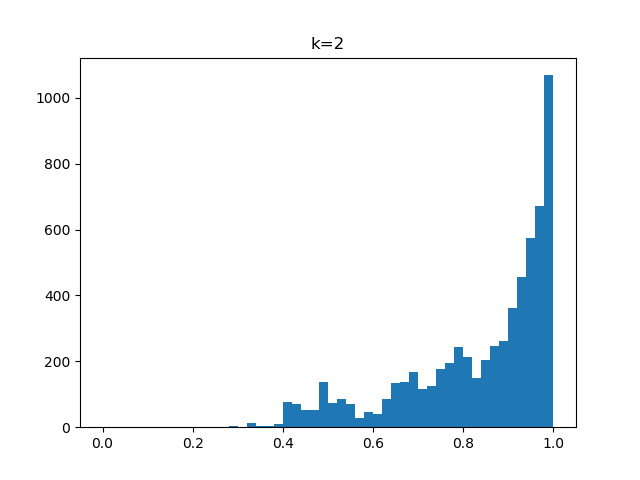

Area of the surface: 1796.078291070351
Average ratio q=2r/R: 0.8349915858512136
0.0596696123005

k=4:


<IPython.core.display.Javascript object>


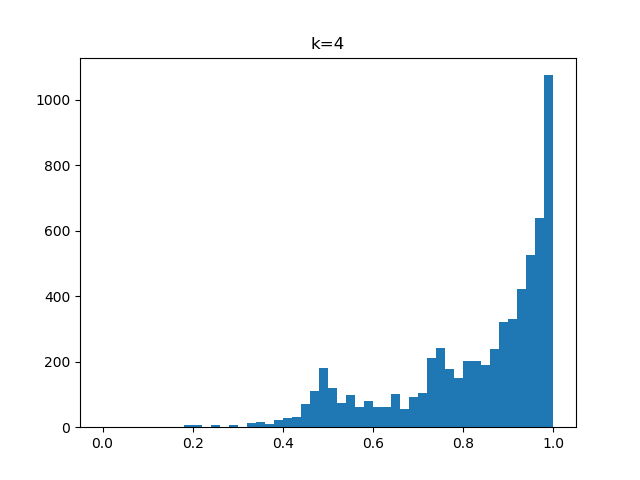

Area of the surface: 1713.1144638282105
Average ratio q=2r/R: 0.8257156961251724
0.0378616131967

k=6:


<IPython.core.display.Javascript object>


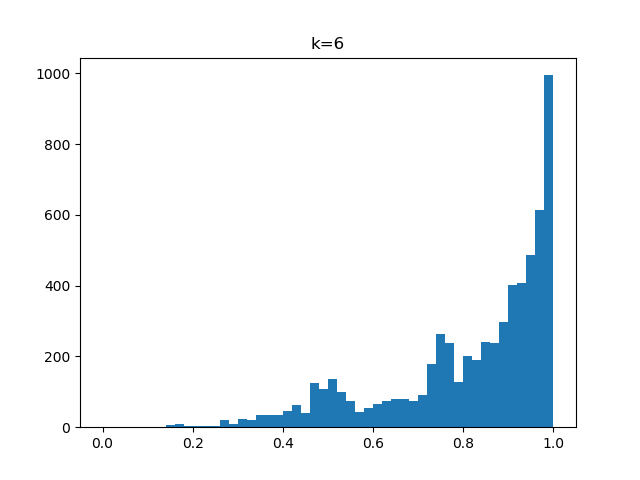

Area of the surface: 1652.025330904301
Average ratio q=2r/R: 0.8152449132185875
0.0285461727339

k=8:


<IPython.core.display.Javascript object>


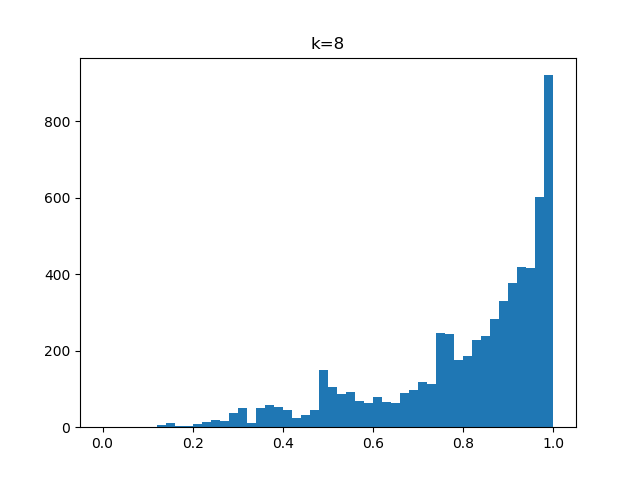

Area of the surface: 1601.2985573312062
Average ratio q=2r/R: 0.8062577896735451
0.0234480754641

k=10:


<IPython.core.display.Javascript object>


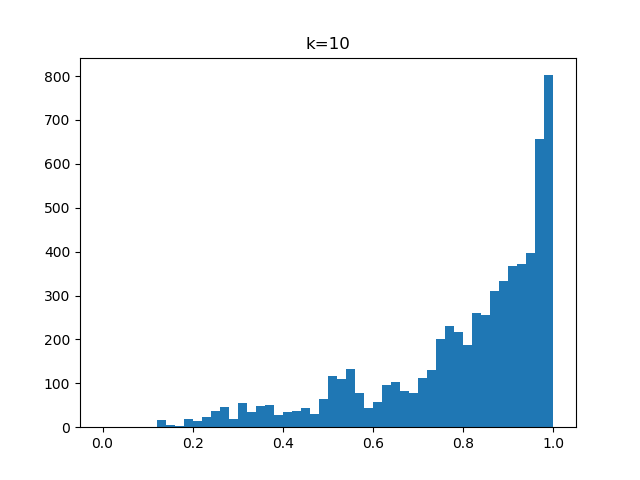

Area of the surface: 1557.0336650818094
Average ratio q=2r/R: 0.798140241327041
0.0202023032349



In [5]:
for k in range(9):
    smoothed_vertices = (L/np.sum(L,axis=1,keepdims=True)).dot(smoothed_vertices)
    if k%2==0:
        print("k={}:".format(k+2))
        draw_histogram(triangles,smoothed_vertices,"k={}".format(k+2))
        print()

The area of the surface is always decreasing. The average ratio reaches its maximum when k=2 and then it also starts to decrease. A possible cause is some triangles begin to collapse after few iterations since the area is always shrinking.